# Voyager Correlation Scale Investigation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import statsmodels.api as sm


# Add .. to the path
import sys
sys.path.append("..")

import src.utils as utils
from src.corr_funcs_claude import *


plt.rcParams.update({"font.size": 9})
plt.rc("text", usetex=True)

Text(0.5, 1.0, 'Voyager 1 LISM data')

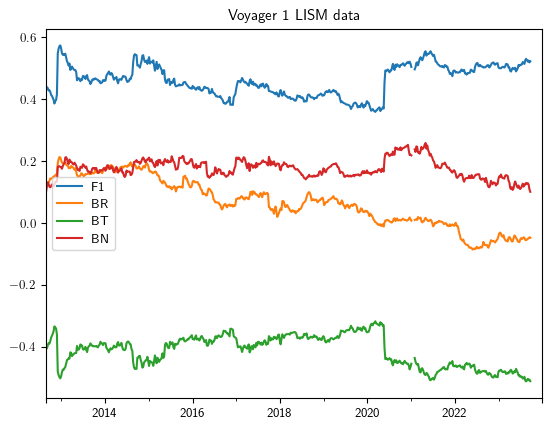

In [24]:
data = pd.read_pickle("../data/interim/voyager/voyager1_lism_cleaned.pkl")
data.resample("7D").mean().plot()
plt.title("Voyager 1 LISM data")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7461001 entries, 2012-08-25 00:00:00 to 2023-12-31 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   F1      float32
 1   BR      float32
 2   BT      float32
 3   BN      float32
dtypes: float32(4)
memory usage: 170.8 MB


In [4]:
# Overlay ACFs from 3 different resamplings of data

# for i, resampling in enumerate(["3h", "6h", "12h", "1d", "2d", "4d"]):
#     data_res = data.resample(resampling).mean()
#     lags, acf = compute_nd_acf(time_series=[data_res["F1"]], time_unit=TimeUnit.DAYS)
#     plt.plot(lags, acf, label=resampling)
# plt.xlabel("Lag (days)")
# plt.ylabel("ACF")
# plt.legend(title="Resampling interval")
# plt.title("ACF of V1 mag for different resampling intervals")


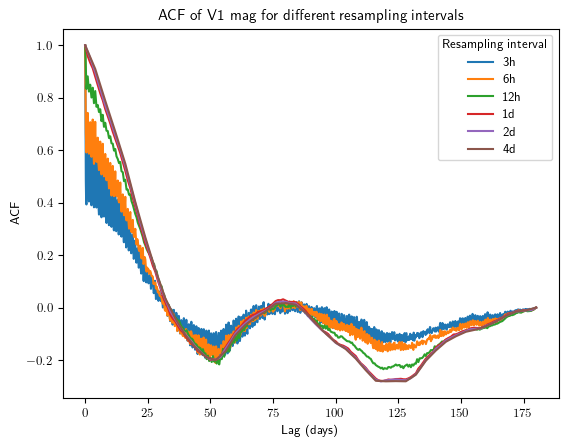

In [5]:
# Finalise resampling to 1D
data_res = data.resample("1d").mean()
data_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4146 entries, 2012-08-25 to 2023-12-31
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      3969 non-null   float32
 1   BR      3969 non-null   float32
 2   BT      3969 non-null   float32
 3   BN      3969 non-null   float32
dtypes: float32(4)
memory usage: 97.2 KB


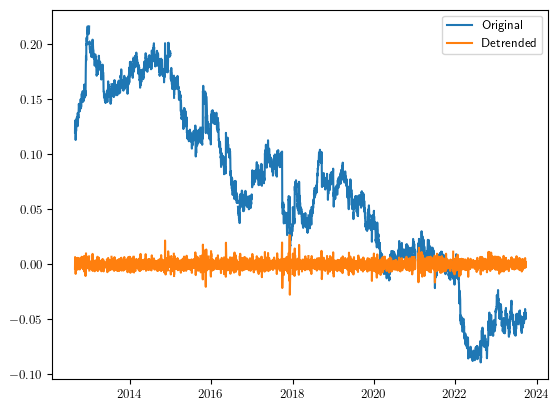

In [6]:
# Create function to remove linear trends from the data, allowing for NAs

def remove_trend(data, time_col, value_col):
    data = data.dropna(subset=[time_col, value_col])
    X = data[time_col].values
    y = data[value_col].values
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    data["residuals"] = results.resid
    return data

data_res["BR_detrended"] = (
    data_res["BR"]
    - data_res["BR"].rolling(window=10, center=True, min_periods=1).mean()
)

plt.plot(data_res["BR"], label="Original")
plt.plot(data_res["BR_detrended"], label="Detrended")
plt.legend()

In [15]:
# First, convert DOY to date
doy_to_date = lambda year, doy: datetime.datetime(year, 1, 1) + datetime.timedelta(
    doy - 1
)
# Set start date to start of Fraternale's interval I2 (312 days long)
#start_date = doy_to_date(2013, 131) # start of I1
start_date = doy_to_date(2014, 184) # start of I2
int_label = "I2"

#end_date = doy_to_date(2015, 131)

In [16]:
# Getting all correlation scales and a combined plot in days

duration_days = np.arange(10, 600, 10)
all_results = []

# for smoothing_window in smoothing_windows:
for duration_days in duration_days:
    end_date = start_date + datetime.timedelta(int(duration_days))
    interval = data_res[start_date:end_date]

    # interval = interval.copy()
    # interval["BR_detrended"] = (
    #     interval["BR"]
    #     - interval["BR"]
    #     .rolling(window=smoothing_window, center=True, min_periods=1)
    #     .mean()
    # )
    # interval["BT_detrended"] = (
    #     interval["BT"]
    #     - interval["BT"].rolling(window=smoothing_window, center=True, min_periods=1).mean()
    # )
    # interval["BN_detrended"] = (
    #     interval["BN"]
    #     - interval["BN"]
    #     .rolling(window=smoothing_window, center=True, min_periods=1)
    #     .mean()
    # )

    # # Make a nice plot showing detrending process for all 3 components
    # fig, axs = plt.subplots(1, 3, figsize=(6, 1.5), sharey=True)
    # for i, component in enumerate(["BR", "BT", "BN"]):
    #     axs[i].plot(interval[component], label="Original")
    #     axs[i].plot(interval[f"{component}_detrended"], label="Detrended")
    #     axs[i].set_title(f"{component}")
    #     axs[0].legend()
    #     # Rotate x-axis labels
    #     axs[i].tick_params(axis="x", rotation=45)

    results = compute_all_correlation_scales(
        [interval.BR, interval.BT, interval.BN],
        time_unit=TimeUnit.DAYS,
        xmax=100, # days
        title=f"Correlation scale estimates from {duration_days} days of Voyager 1 data",
    )
    # Add duration to results
    results["interval_duration"] = duration_days
    # results["smoothing_window"] = smoothing_window
    # results["figure_time_series"] = fig

    all_results.append(results)

# # Combine all results into a dataframe
results_df = pd.DataFrame(all_results)

c:\Users\spann\Documents\Research\Code repos\sf_gap_analysis\notebooks\..\src\corr_funcs_claude.py:289: OptimizeWarning: Covariance of the parameters could not be estimated
  c_opt, _ = curve_fit(


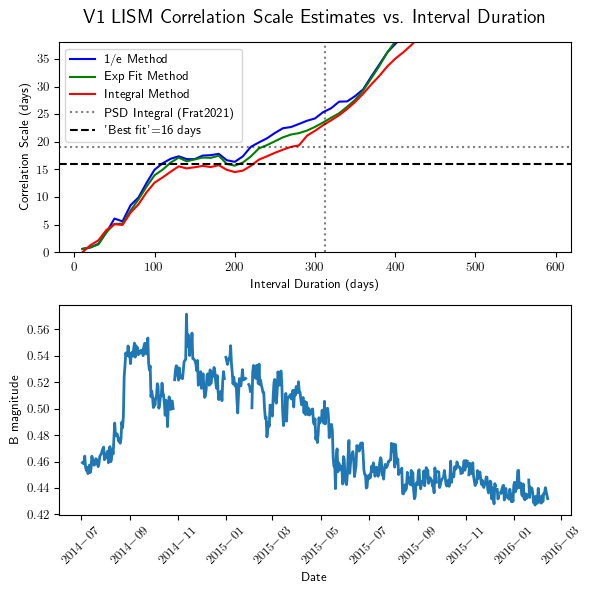

In [23]:
df = results_df

# Unique smoothing window values
# smoothing_windows = df["smoothing_window"].unique()

# Plot each method separately
methods = {
    "correlation_scale_1/e": "1/e Method",
    "correlation_scale_exp_fit": "Exp Fit Method",
    "correlation_scale_integral": "Integral Method",
}

colors = ['blue', 'green', 'red']

# fig, axs = plt.subplots(1, len(smoothing_windows), figsize=(15, 3), sharey=True)

# for i, window in enumerate(smoothing_windows):
#     subset = df[df["smoothing_window"] == window]
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot correlation scale estimates
for method, label in methods.items():
    axs[0].plot(
        df["interval_duration"],
        df[method],
        color=colors[list(methods.keys()).index(method)],
        label=label,
    )

axs[0].axvline(
    312,
    color="black",
    linestyle="dotted",
    alpha=0.5,
    label="PSD Integral (Frat2021)",
)
axs[0].axhline(19, color="black", linestyle="dotted", alpha=0.5)
axs[0].set_xlabel("Interval Duration (days)")
axs[0].set_ylabel("Correlation Scale (days)")
axs[0].axhline(16, color="black", linestyle="--", label="'Best fit'=16 days")
axs[0].set_title("V1 LISM Correlation Scale Estimates vs. Interval Duration", y=1.05, fontsize=14)

axs[0].legend()
axs[0].set_ylim(0, 38)


# Plot interval
end_date = start_date + datetime.timedelta(400)
axs[1].plot(interval["F1"], lw=2)
axs[1].set_xlabel("Date")
axs[1].set_ylabel("B magnitude")
# Rotate x-axis labels
axs[1].tick_params(axis="x", rotation=45)


plt.tight_layout()
plt.savefig(f"../results/cleaning/v1_lism_corr_scale_int_{int_label}.png", dpi=300)
plt.show()

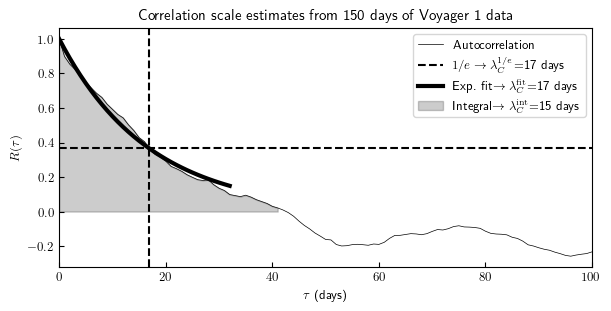

In [20]:
# Display the ACF figure for the interval duration of 300 days
results_df[results_df["interval_duration"] == 150]["figure_acf"].values[0]

## Taylor scale

Looks like Fraternale's Fig 3a inset - but not very parabolic!!

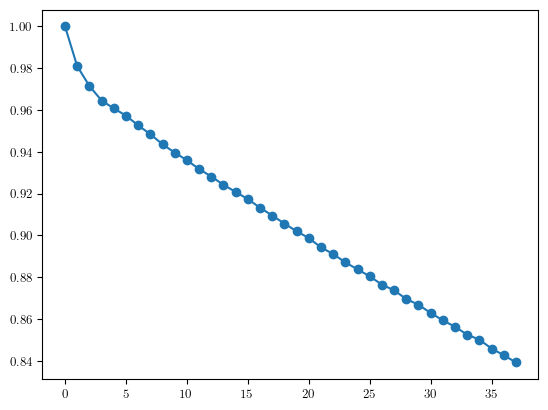

In [19]:
acf = sm.tsa.acf(
    data["F1"], nlags=int(1800/ 48), missing="conservative"
)
plt.plot(acf, marker="o")